# Python for Financial Analysis




## Adam Shackleton - PyNW Jan 2021

## Agenda
- The Disclaimer
- The Libraries
- The Data
- The Models
    - Buy and hold
    - Fast vs slow
    - Multiple linear regression

## Disclaimer

None of the things I say today are "advice" and should not be mistaken for advice.

If you came looking for step one in the two step process:

1. ?
2. Profit

you won't find it. Stock data is basically random (we'll discuss exactly how random shortly). There isn't an easy way to model it which guarantees making loads of money. Sorry, you're not going to be Warren Buffett by 7:30pm.

Let's look at the libraries we're going to use:

In [12]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

import yfinance as yf

import scipy.stats as stats
from scipy.stats import norm
import statsmodels.formula.api as smf

Let's have a look at some stock data.

We'll use the yfinance library to get some historical data

In [199]:
dsy = yf.Ticker("DSY.PA")
#data = pd.DataFrame(dsy.history(period="2y"))

data = pd.DataFrame(dsy.history(start="2016-01-01", end="2019-01-01"))
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2016-01-04,71.178933,71.412368,69.077993,69.583778,235395,0.0,0
2016-01-05,70.556427,70.887126,69.136351,69.700493,214272,0.0,0
2016-01-06,69.661592,69.690771,68.105337,68.854286,222971,0.0,0
2016-01-07,67.298034,68.494396,66.675535,68.406860,328064,0.0,0
2016-01-08,67.794080,68.883457,67.482830,67.512016,277586,0.0,0


In [200]:
data['Return'] = data['Close'] - data['Close'].shift(1)

data['LogReturn'] = np.log(data['Close']) - np.log(data['Close'].shift(1))
data.dropna()
data['positive'] = [1 if ret > 0 else 0 for ret in data['LogReturn']]
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Return,LogReturn,positive
Date,,,,,,,,,,
2016-01-04,71.178933,71.412368,69.077993,69.583778,235395,0.0,0,NaN,NaN,0
2016-01-05,70.556427,70.887126,69.136351,69.700493,214272,0.0,0,0.116714,0.001676,1
2016-01-06,69.661592,69.690771,68.105337,68.854286,222971,0.0,0,-0.846207,-0.012215,0
2016-01-07,67.298034,68.494396,66.675535,68.406860,328064,0.0,0,-0.447426,-0.006519,0
2016-01-08,67.794080,68.883457,67.482830,67.512016,277586,0.0,0,-0.894844,-0.013168,0


Let's plot a histogram of the return data to see what it looks like

We'll overlay a normal distribution curve to see how close to that the data is

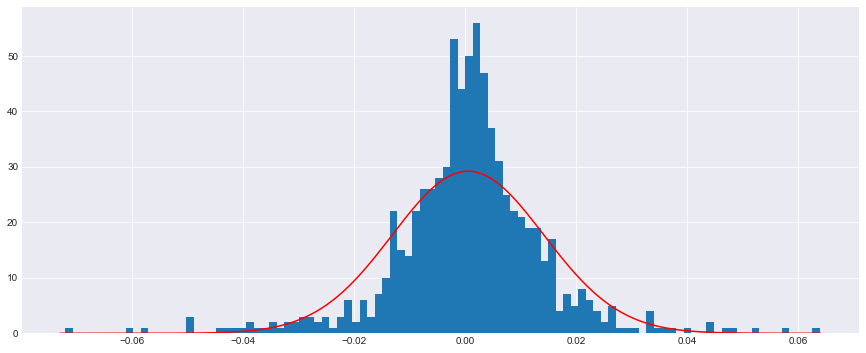

In [194]:
mu = data['LogReturn'].mean()
sigma = data.LogReturn.std(ddof=1) # this is a sample of the data, so we use ddof=1

density = pd.DataFrame()
density['x'] = np.arange(data['LogReturn'].min()-0.001, data['LogReturn'].max()+0.001, 0.001)
density['pdf'] = norm.pdf(density['x'], mu, sigma)

data['LogReturn'].hist(bins=100, figsize=(15, 6))
plt.plot(density['x'], density['pdf'], color='red')
plt.show()

In [187]:
data['LogReturn'].describe()

count    766.000000
mean       0.000508
std        0.013645
min       -0.071981
25%       -0.005573
50%        0.000976
75%        0.006919
max        0.063812
Name: LogReturn, dtype: float64

In [195]:
VaR = norm.ppf(0.05, mu, sigma)
print('Single day value at risk ', VaR)

Single day value at risk  -0.02193569487942943


I didn't talk about Value at Risk during the talk, but it's represents the size of the biggest possible loss that has a 95% probability. It's sort of the answer to the question:

What's the worst possible scenario that is vaguely likely?

Obviously we could ask the opposite question, what's the highest possible gain that's vaguely likely, but people seem to be less worried about that.





percentage positive: 53.0638852672751


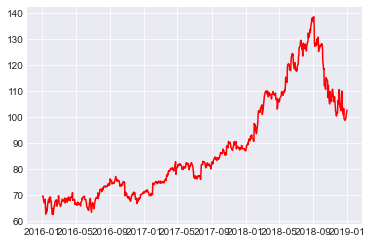

In [196]:
print("percentage positive:",100 * data.positive.cumsum()[-1] / len(data.positive))
plt.plot(data['Close'], color='red')
plt.show()

Buying and holding a number of stocks, rebalancing them on a regular basis.

Rebalancing is the act of selling some of you assets that have performed above average and using the cash to buy more of the assets that made less profit, to keep the split of each of your holdings constant.

In our case we'll assume we hold an equal amount of all the assets, but we could skew this in favour of certain ones if we wanted.

We rebalance for two reasons:

1. To enforce a "buy low; sell high" mentality. We sell the profit from our "high" stocks, and buy more of our "low" stocks
2. To maintain a consistent level of exposure (risk) in our portfolio

It is not so much a profit maximising scheme as a risk minimising one.

In [201]:
data = yf.download("OCDO.L BARC.L BRBY.L AZN.L CCH.L ADM.L RMV.L SVT.L", 
                   period="10y", group_by="ticker")

Ocado = data['OCDO.L']
Barclays = data['BARC.L']
Burbury = data['BRBY.L']
AstraZeneca = data['AZN.L']
CocaCola = data['CCH.L']
Admiral = data['ADM.L']
RightMove = data['RMV.L']
SevernTrent = data['SVT.L']

[*********************100%***********************]  8 of 8 completed


In [202]:
trading_data = pd.DataFrame(index=Ocado.index)

trading_data['Ocado']=Ocado['Close']
trading_data['Barclays']=Barclays['Close']
trading_data['Burbury']=Burbury["Close"]
trading_data['AstraZeneca']=AstraZeneca['Close']
trading_data['CocaCola']=CocaCola['Close']
trading_data['Admiral']=Admiral['Close']
trading_data['RightMove']=RightMove['Close']
trading_data['SevernTrent']=SevernTrent['Close']

trading_data = trading_data.dropna()
trading_data.head()

,Ocado,Barclays,Burbury,AstraZeneca,CocaCola,Admiral,RightMove,SevernTrent
Date,,,,,,,,
2013-04-29,167.199997,267.794006,1344.0,3362.5,1750.0,1325.0,188.399994,1818.0
2013-04-30,170.000000,264.237000,1336.0,3342.5,1690.0,1281.0,192.100006,1821.0
2013-05-01,168.000000,266.684998,1314.0,3334.0,1630.0,1241.0,194.199997,1823.0
2013-05-02,171.899994,266.869995,1319.0,3317.0,1615.0,1233.0,193.199997,1819.0
2013-05-03,176.000000,273.520996,1378.0,3339.5,1610.0,1259.0,193.199997,1815.0


In [203]:
# Convert daily to monthly frequency, simluates a monthly rebalancing
monthly_stocks_data = trading_data.asfreq('M')
monthly_stocks_data = monthly_stocks_data.dropna()

monthly_percent_change = monthly_stocks_data.pct_change()

monthly_percent_change = monthly_percent_change.dropna()
monthly_percent_change.head()

,Ocado,Barclays,Burbury,AstraZeneca,CocaCola,Admiral,RightMove,SevernTrent
Date,,,,,,,,
2013-05-31,0.598823,0.120259,0.087575,0.013613,0.093491,0.044496,0.065070,0.126853
2013-07-31,0.131347,-0.101576,0.052994,-0.015643,-0.073593,0.048580,0.188172,-0.135965
2013-09-30,0.287805,-0.001677,0.067974,-0.035832,0.080607,-0.121169,-0.025504,-0.005640
2013-10-31,0.095960,-0.007156,-0.060588,0.029078,-0.025946,0.037307,0.119460,0.053318
2014-01-31,0.205069,0.033763,-0.056678,0.166062,-0.104883,0.129789,-0.045249,-0.070005


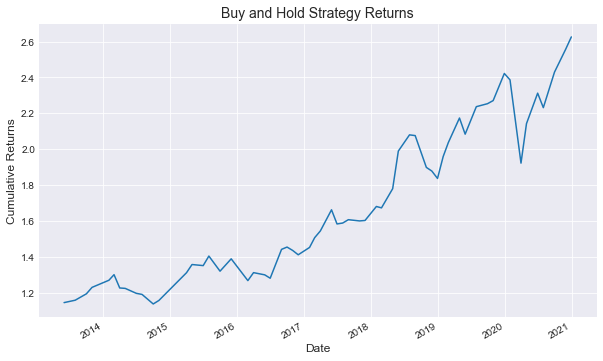

In [205]:
portfolio_returns = monthly_percent_change.mean(axis=1)
cum_portfolio_returns = (portfolio_returns+1).cumprod()
plt.style.use('seaborn-darkgrid')
cum_portfolio_returns.plot(figsize=(10, 6))

plt.title('Buy and Hold Strategy Returns', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Returns', fontsize=12)
plt.show()

## Fast Signal vs Slow Signal

The idea is that by tracking the rate at which a stock is changing over different time frames, the point at which there is a shift in momemtum can be seen. 

When a stock's fast and slow signals cross, it is considered to be an indicator that the stock is overbought - meaning its price is likely to fall, or oversold - meaning it's price is likely to rise.

In [210]:
ticker = yf.Ticker("MSFT")
msft = pd.DataFrame(ticker.history(period="5y"))
msft['Return'] = msft['Close'].shift(-1) - msft['Close']
msft['BandH'] = msft['Return'].cumsum()
msft = msft.dropna()

msft.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Return,BandH
Date,,,,,,,,,
2016-01-20,45.608344,46.885890,44.805315,46.347496,63273000,0.0,0,-0.282890,-0.282890
2016-01-21,46.539123,47.068393,45.900350,46.064606,40191200,0.0,0,1.651684,1.368793
2016-01-22,46.913261,47.752792,46.776379,47.716290,37555800,0.0,0,-0.456272,0.912521
2016-01-25,47.396895,48.044795,47.132264,47.260017,34707700,0.0,0,0.346771,1.259293
2016-01-26,47.260029,47.853173,47.041020,47.606789,28900800,0.0,0,-0.866909,0.392384


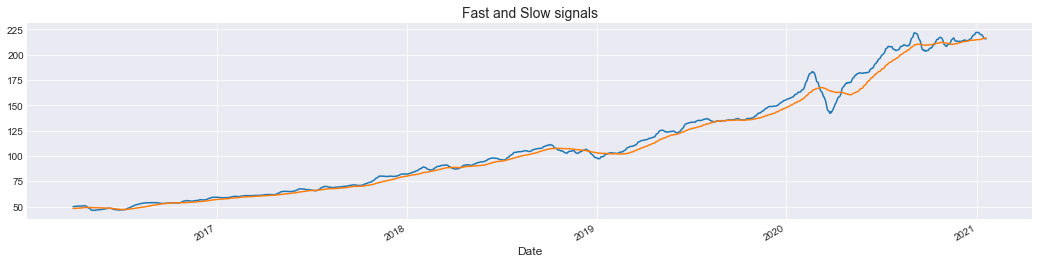

In [211]:
msft['fast'] = msft['Close'].rolling(10).mean()
msft['slow'] = msft['Close'].rolling(50).mean()

msft = msft.dropna()
msft.fast.plot(figsize=(18, 4))
msft.slow.plot()
plt.title('Fast and Slow signals', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.show()

In [ ]:
msft['stock'] = [1 if msft.loc[i, 'fast'] > msft.loc[i, 'slow'] 
                 and msft.loc[i, 'fast'] > 80 else 0 for i in msft.index]
msft['Profit'] = msft['Return'] * msft['stock']
msft['Wealth'] = msft['Profit'].cumsum()
msft.Wealth.plot(figsize=(15, 6))
msft.BandH.plot(figsize=(15, 6))
plt.title('Fast and Slow signal Wealth', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.legend()
plt.show()

## The Stochastic Oscillator

A momentum indicator used in technical analysis of stocks

Introduced by George Lane in the 1950s 

Compares the closing price of a commodity to its price range over a given time span

When the value is 0 it means the current close is lowest value the price has been in the analysed period, when it's 100  the price is the highest of the recent period.

Generally the overbought : oversold levels are 80 : 20

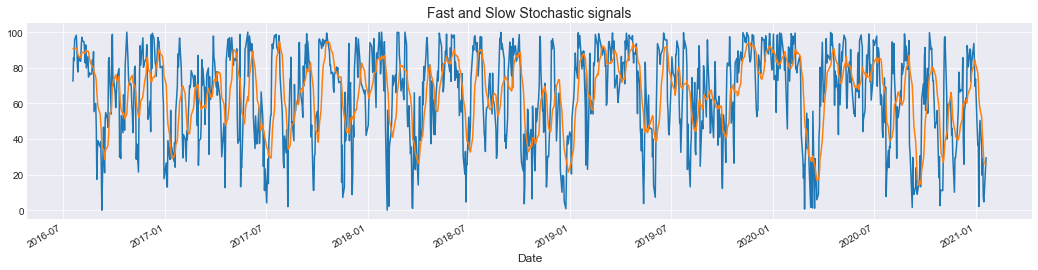

In [216]:
msft['fast_stoch'] = ((msft['Close'] - msft['Low'].rolling(14).min()) / 
               (msft['High'].rolling(14).max() - msft['Low'].rolling(14).min())) * 100
msft['slow_stoch'] = msft['fast_stoch'].rolling(10).mean()

msft = msft.dropna()
msft.fast_stoch.plot(figsize=(18, 4))
msft.slow_stoch.plot()
plt.title('Fast and Slow Stochastic signals', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.show()

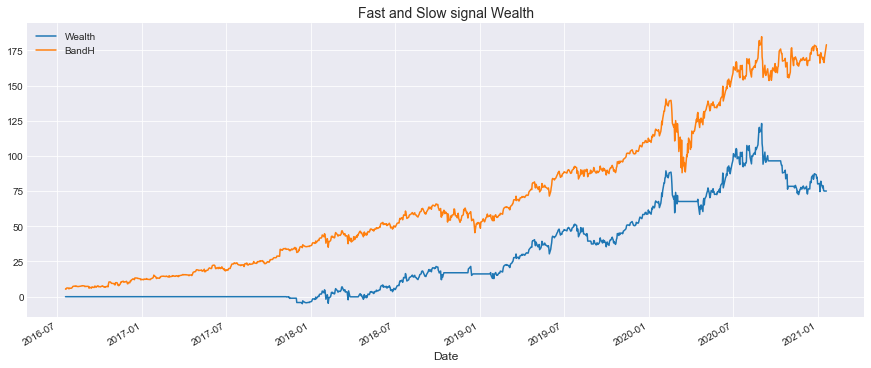

In [219]:
msft['stock'] = [1 if msft.loc[i, 'fast'] > msft.loc[i, 'slow'] 
                 and msft.loc[i, 'fast'] > 80 else 0 for i in msft.index]
# if the fast is above the slow and the fast is above 80 then we buy
# we could consider a "short" position if the opposite is true

msft['Profit'] = msft['Return'] * msft['stock']
msft['Wealth'] = msft['Profit'].cumsum()
msft.Wealth.plot(figsize=(15, 6))
msft.BandH.plot(figsize=(15, 6))
plt.title('Fast and Slow signal Wealth', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.legend()
plt.show()

## Multiple Linear Regression

Next we will try a slightly more sophisticated model for our stock data

Using multiple linear regression we will try to build a prediction engine from a training data set and use it on a test data set to see if we can beat the buy and hold strategy

In linear regression we are trying to calculate coefficients for predictors. In simple linear regression we have only one predictor e.g.

y = mx

x is our predictor and m is the coefficient we are trying to calculate. There might also be an intercept term i.e. 

y = mx + c

Linear regression algorithms work by trying many many values of m and c and each time working out the predicted value for y for all the known x values. We then compare each predicted y to the actual value of y in the data but subtracting one from the other and squaring the result (which ensures it's always positive). We total these values to give us a "sum of squared errors". The values of m and c selected are the ones that minimise the squared error.

Multiple linear regression is the same princple except we have many m's and many x's i.e.

y = c + m1x1 + m2x2 + m3x3 + m4x4 etc

## VSS

VSS is an exchange-traded fund or ETF

It's a collection of stocks that is trying to track the performance of some market or group of shares

*My recommendation is to go with the Vanguard FTSE All-World ex-US Small-Cap ETF, 
a fund that tracks the performance of the FTSE Global Small Cap ex US Index, 
which consists of over 3,000 stocks in dozens of countries*

Some panel decide what trades to make to rebalance the fund for you, meaning that it is likely to get a return equivalent to that of the entity it's tracking

## Our Predictors

To predict the performance of VSS, we'll look at most of the main global markets

Since VSS is traded in the United States, we'll use the difference between the current day's opening and closing prices for Australian and Far East markets (where the markets have already closed), and the difference between today's and yesterday's opening prices for European and US markets.



In [237]:
data = yf.download("VSS ^AORD ^N225 ^HSI ^GDAXI ^FCHI ^GSPC ^DJI ^IXIC ^FTSE", 
                   start="2010-01-01", end="2018-08-22", group_by="ticker")

[*********************100%***********************]  10 of 10 completed


In [238]:
aord = data['^AORD']
nikkei = data['^N225']
hsi = data['^HSI']
daxi = data['^GDAXI']
cac40 = data['^FCHI']
ftse = data['^FTSE']
sp500 = data['^GSPC']
dji = data['^DJI']
nasdaq = data['^IXIC']
vss = data['VSS']

In [252]:
indicepanel=pd.DataFrame(index=vss.index)

indicepanel['vss']=vss['Open'].shift(-1)-vss['Open']
indicepanel['vss_lag1']=indicepanel['vss'].shift(1)
indicepanel['sp500']=sp500["Open"]-sp500['Open'].shift(1)
indicepanel['nasdaq']=nasdaq['Open']-nasdaq['Open'].shift(1)
indicepanel['dji']=dji['Open']-dji['Open'].shift(1)

indicepanel['cac40']=cac40['Open']-cac40['Open'].shift(1)
indicepanel['daxi']=daxi['Open']-daxi['Open'].shift(1)
indicepanel['ftse']=ftse['Open']-ftse['Open'].shift(1)

indicepanel['aord']=aord['Close']-aord['Open']
indicepanel['hsi']=hsi['Close']-hsi['Open']
indicepanel['nikkei']=nikkei['Close']-nikkei['Open']
indicepanel['Price']=vss['Open']

In [254]:
indicepanel = indicepanel.fillna(method='ffill')
indicepanel = indicepanel.dropna()
indicepanel.isnull().sum()

Train = indicepanel.iloc[-2000:-1000, :]
Test = indicepanel.iloc[-1000:, :]

Train.head()

,vss,vss_lag1,sp500,nasdaq,dji,cac40,daxi,ftse,aord,hsi,nikkei,Price
Date,,,,,,,,,,,,
2010-12-15,-0.500000,-0.589996,-0.260010,-5.530029,46.399414,-4.119873,-17.299805,30.400391,2.399902,-395.990234,-28.359375,99.760002
2010-12-16,0.000000,-0.500000,-5.239990,-5.250000,-17.709961,-11.590088,5.500000,-9.000000,18.099609,-281.000000,13.740234,99.260002
2010-12-17,0.159996,0.000000,7.290039,22.790039,41.089844,23.169922,29.839844,-1.100098,-15.500000,53.968750,-3.339844,99.260002
2010-12-20,0.389999,0.159996,2.130005,8.629883,-7.719727,-28.179932,-42.450195,-9.300293,-24.599609,-69.349609,-80.139648,99.419998
2010-12-21,-2.540001,0.389999,3.670044,6.959961,-12.939453,29.919922,44.870117,19.800293,28.200195,282.398438,93.390625,99.809998


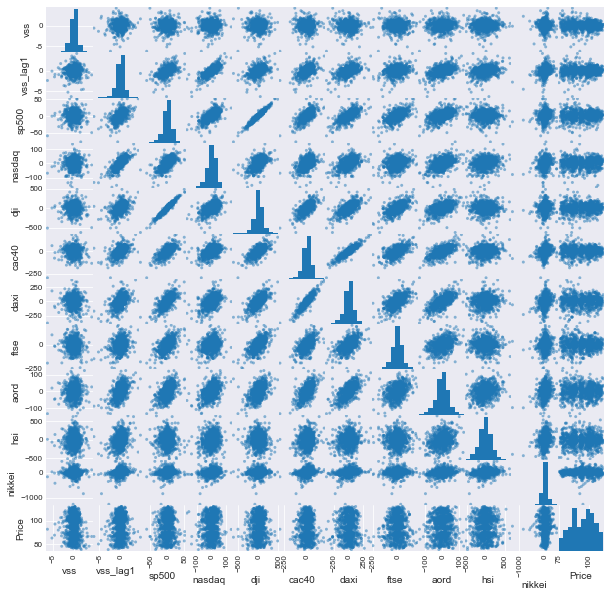

In [256]:
sm = scatter_matrix(Train, figsize=(10, 10))

In [244]:
corr_array = Train.iloc[:, :-1].corr()['vss']
print(corr_array)

vss         1.000000
vss_lag1    0.067340
sp500       0.024885
nasdaq      0.048272
dji        -0.000108
cac40       0.003954
daxi       -0.006171
ftse       -0.015678
aord        0.065446
hsi         0.042427
nikkei     -0.003756
Name: vss, dtype: float64


In [267]:
formula = 'vss~vss_lag1+sp500+nasdaq+dji+cac40+aord+daxi+nikkei+hsi+ftse'
lm = smf.ols(formula=formula, data=Train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    vss   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.993
Date:                Wed, 20 Jan 2021   Prob (F-statistic):             0.0311
Time:                        21:30:57   Log-Likelihood:                -1387.6
No. Observations:                1000   AIC:                             2797.
Df Residuals:                     989   BIC:                             2851.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0049      0.031     -0.159      0.874      -0.066       0.056
vss_lag1       0.0849      0.053      1.604      0.109      -0.019       0.189
sp500          0.0277      0.011      2.537      0.011       0.006       0.049
nasdaq        -0.0024      0.002     -1.265      0.206      -0.006       0.001
dji           -0.0027      0.001     -2.368      0.018      -0.005      -0.000
cac40      -6.188e-05      0.002     -0.037      0.970      -0.003       0.003
aord           0.0029      0.001      2.398      0.017       0.001       0.005
daxi          -0.0010      0.001     -1.190      0.234      -0.003       0.001
nikkei        -0.0003      0.000     -0.926      0.355      -0.001       0.000
hsi            0.0001      0.000      0.531      0.596      -0.000       0.001
ftse          -0.0004      0.001     -0.463      0.644      -0.002       0.001
==============================================================================
Omnibus:                      147.182   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              673.361
Skew:                          -0.601   Prob(JB):                    6.05e-147
Kurtosis:                       6.836   Cond. No.                         296.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## What's that telling us?

Well the **Prob (F-Statistic)** tells us whether or not our model is going to be much use

If the value is greater than 0.05 we accept the null hypothesis, which in this case is that all of our coefficients are pointless and we might as well use the intercept for our model

Fortunately that's not the case, so we know at least one of our model coefficients is useful

In [268]:
import warnings
warnings.filterwarnings("ignore")

Train['PredictedY'] = lm.predict(Train)
Test['PredictedY'] = lm.predict(Test)

In the last cell we applied the coefficients calculated using the model to our training and test data sets (remember we used the training data set to create the model)

Now we're going to cover the result into a signal. If the result is positive we will buy the stock today and if it is negative we will "short" the stock - which means we will bet against it. When we short a stock a negative performance is beneficial for us. In our model 1 is buy and -1 is short.

In [269]:
Train['Stock'] = [1 if sig>0 else -1 for sig in Train['PredictedY']]
Train['Profit'] = Train['vss'] * Train['Stock']

Train['Wealth'] = Train['Profit'].cumsum()
print('Total profit made in Train: ', Train['Profit'].sum())
Train.head()

Total profit made in Train:  95.63005828857422


,vss,vss_lag1,sp500,nasdaq,dji,cac40,daxi,ftse,aord,hsi,nikkei,Price,PredictedY,Stock,Profit,Wealth
Date,,,,,,,,,,,,,,,,
2010-12-15,-0.500000,-0.589996,-0.260010,-5.530029,46.399414,-4.119873,-17.299805,30.400391,2.399902,-395.990234,-28.359375,99.760002,-0.198397,-1,0.500000,0.500000
2010-12-16,0.000000,-0.500000,-5.239990,-5.250000,-17.709961,-11.590088,5.500000,-9.000000,18.099609,-281.000000,13.740234,99.260002,-0.115006,-1,-0.000000,0.500000
2010-12-17,0.159996,0.000000,7.290039,22.790039,41.089844,23.169922,29.839844,-1.100098,-15.500000,53.968750,-3.339844,99.260002,-0.039262,-1,-0.159996,0.340004
2010-12-20,0.389999,0.159996,2.130005,8.629883,-7.719727,-28.179932,-42.450195,-9.300293,-24.599609,-69.349609,-80.139648,99.419998,0.058025,1,0.389999,0.730003
2010-12-21,-2.540001,0.389999,3.670044,6.959961,-12.939453,29.919922,44.870117,19.800293,28.200195,282.398438,93.390625,99.809998,0.182968,1,-2.540001,-1.809998


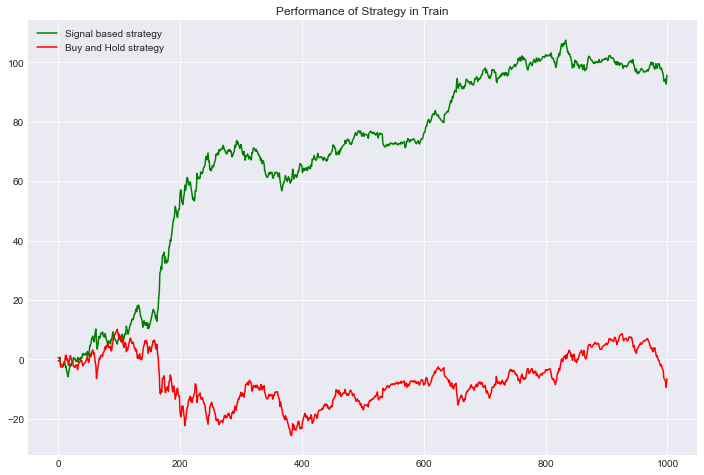

In [270]:
plt.figure(figsize=(12, 8))
plt.title('Performance of Strategy in Train')
plt.plot(Train['Wealth'].values, color='green', label='Signal based strategy')
plt.plot(Train['vss'].cumsum().values, color='red', label='Buy and Hold strategy')
plt.legend()
plt.show()

In [274]:
Test['Stock'] = [1 if sig>0 else -1 for sig in Test['PredictedY']]
Test['Profit'] = Test['vss'] * Test['Stock']

Test['Wealth'] = Test['Profit'].cumsum()
print('Total profit made in Test: ', Test['Profit'].sum())

Total profit made in Test:  26.83000946044922


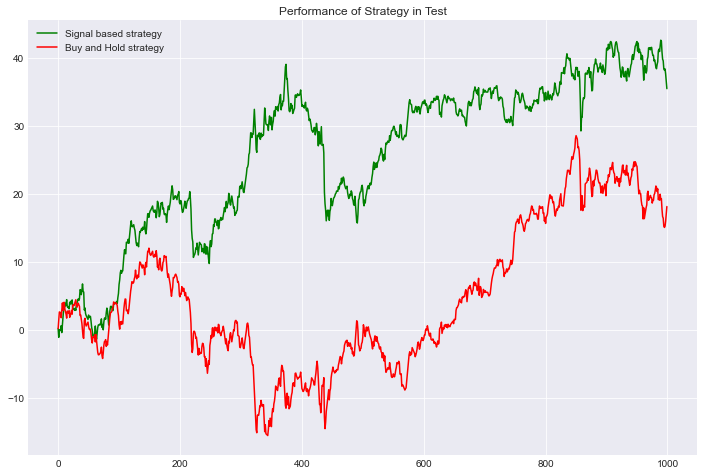

In [272]:
plt.figure(figsize=(12, 8))
plt.title('Performance of Strategy in Test')
plt.plot(Test['Wealth'].values, color='green', label='Signal based strategy')
plt.plot(Test['vss'].cumsum().values, color='red', label='Buy and Hold strategy')
plt.legend()
plt.show()